### Airline Passenger Demand Forecasting - Auto ARIMA

<li>Make series stationary: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations</li>
<li>Determine d value: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
Create ACF and PACF plots: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model</li>
<li>Determine the p and q values: Read the values of p and q from the plots in the previous step</li>
<li>Fit ARIMA model: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model</li>
<li>Predict values on validation set: Predict the future values</li>
<li>Calculate RMSE: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set</li>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import seaborn as sns


import sklearn.metrics as sklm
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX
from statsmodels.tsa.arima_model import ARIMA

import itertools
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("AirPassengers.csv", index_col=0)

df.head()

,Passengers
TravelDate,
1/1/1949,112
2/1/1949,118
3/1/1949,132
4/1/1949,129
5/1/1949,121


In [53]:
df.shape

(144, 1)

In [54]:
# split into train and test sets
train=df[0:100]
test=df[100:]

In [55]:
# convert index to date / time
df.index = pd.to_datetime(df.index)
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

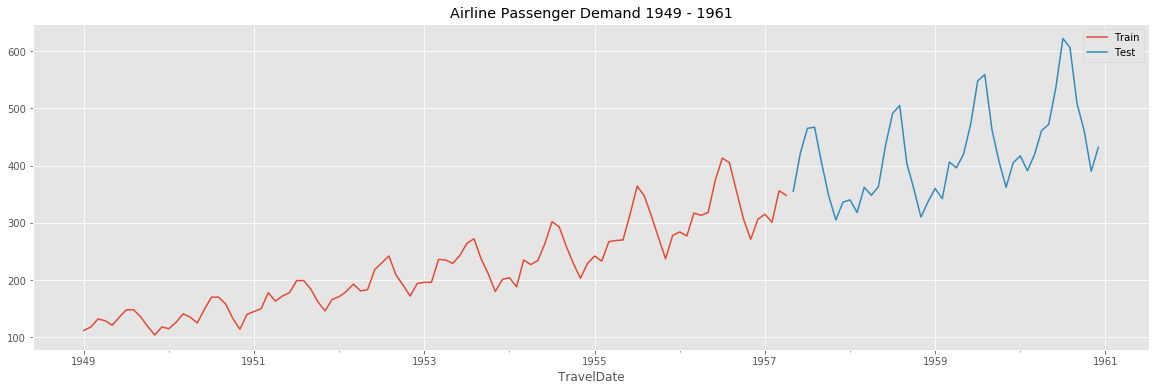

In [56]:
train['Passengers'].plot(figsize=(20,6))
test['Passengers'].plot(figsize=(20,6))
plt.legend(['Train','Test'])
plt.title("Airline Passenger Demand 1949 - 1961")
plt.show()

### Rolling Statistics

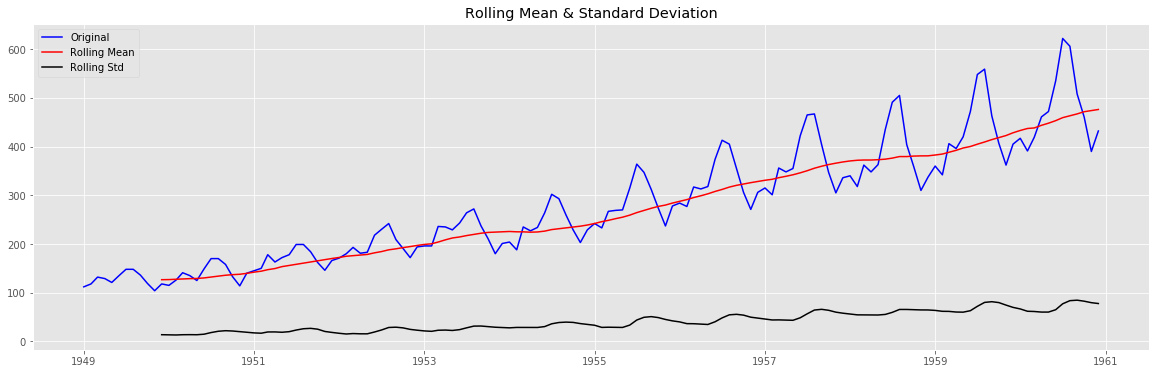

In [57]:
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

#Plot rolling statistics:
plt.figure(figsize=(20,6))
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [58]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


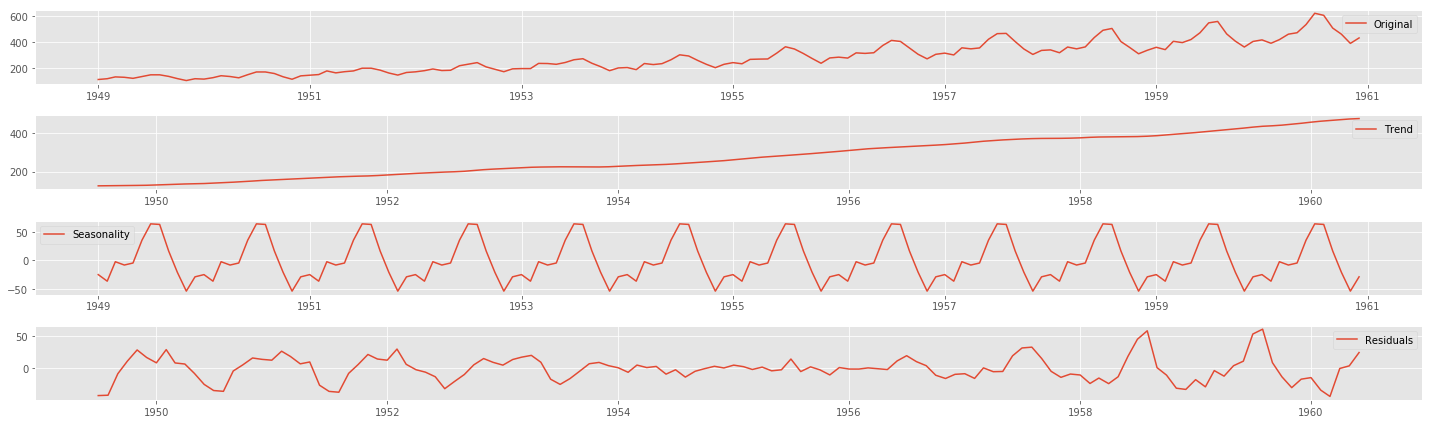

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,6))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Auto ARIMA Example

In [60]:
#building the model
from pyramid.arima import auto_arima

auto_model = auto_arima(train, start_p=0, start_q=0, max_p=8, max_q=8, start_P=0, start_Q=0, max_P=8, max_Q=8, m=12, seasonal=True, trace=True,
                   d=1, D=1, error_action='warn', suppress_warnings=True, stepwise=True, random_state=20, n_fits=30)
                   
auto_model.fit(train)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=652.680, BIC=657.612, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=645.943, BIC=655.806, Fit time=0.255 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=646.447, BIC=656.311, Fit time=0.216 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=647.792, BIC=655.190, Fit time=0.067 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=647.917, BIC=660.247, Fit time=0.702 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=647.931, BIC=660.261, Fit time=0.433 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=645.798, BIC=660.593, Fit time=2.059 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=652.514, BIC=664.843, Fit time=0.790 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=647.724, BIC=664.985, Fit time=2.650 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [61]:
forecast = auto_model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Auto_ARIMA'])

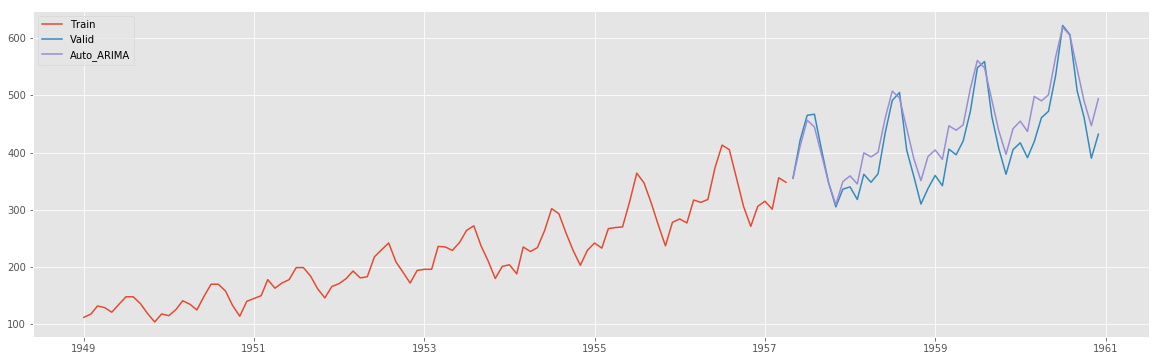

In [62]:
#plot the predictions for validation set
plt.figure(figsize=(20,6))
plt.plot(train, label='Train')
plt.plot(test, label='Valid')
plt.plot(forecast, label='Auto_ARIMA')
plt.legend(loc='best')
plt.show()

In [63]:
rms = sqrt(mean_squared_error(test['Passengers'], forecast.Auto_ARIMA))
print("RMSE = " + str(rms))
print("R^2  = " + str(sklm.r2_score(test['Passengers'], forecast.Auto_ARIMA)))

RMSE = 34.23169296156854
R^2  = 0.7994873265174851


### Manual Seasonal ARIMA Model

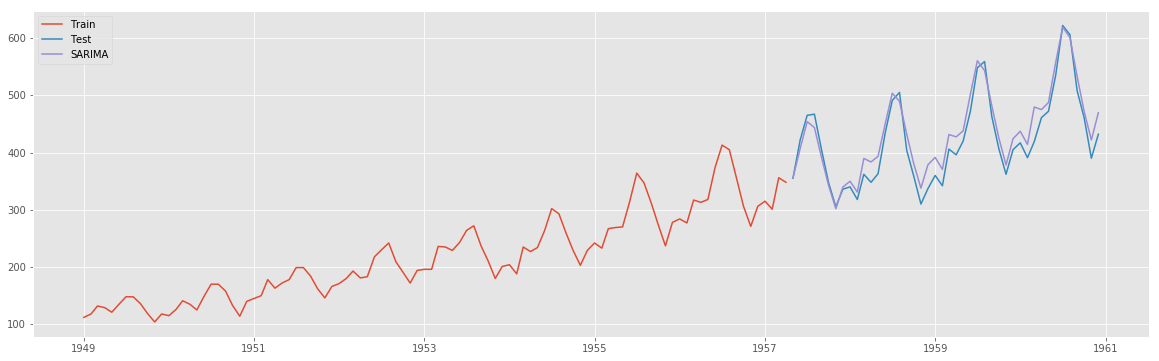

In [64]:
forecast = test.copy()
model = sm.tsa.statespace.SARIMAX(train['Passengers'], order=(3, 1, 1), seasonal_order=(3,2,1,12), enforce_invertibility=False).fit()
forecast['SARIMA'] = model.predict(start="1957-05-01", end="1961-12-01", dynamic=True, )
plt.figure(figsize=(20,6))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(forecast['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [65]:
rms = sqrt(mean_squared_error(test['Passengers'], forecast['SARIMA']))
print("RMSE = " + str(rms))
print("R^2  = " + str(sklm.r2_score(test['Passengers'], forecast['SARIMA'])))

RMSE = 23.30587974144723
R^2  = 0.9070571311467939


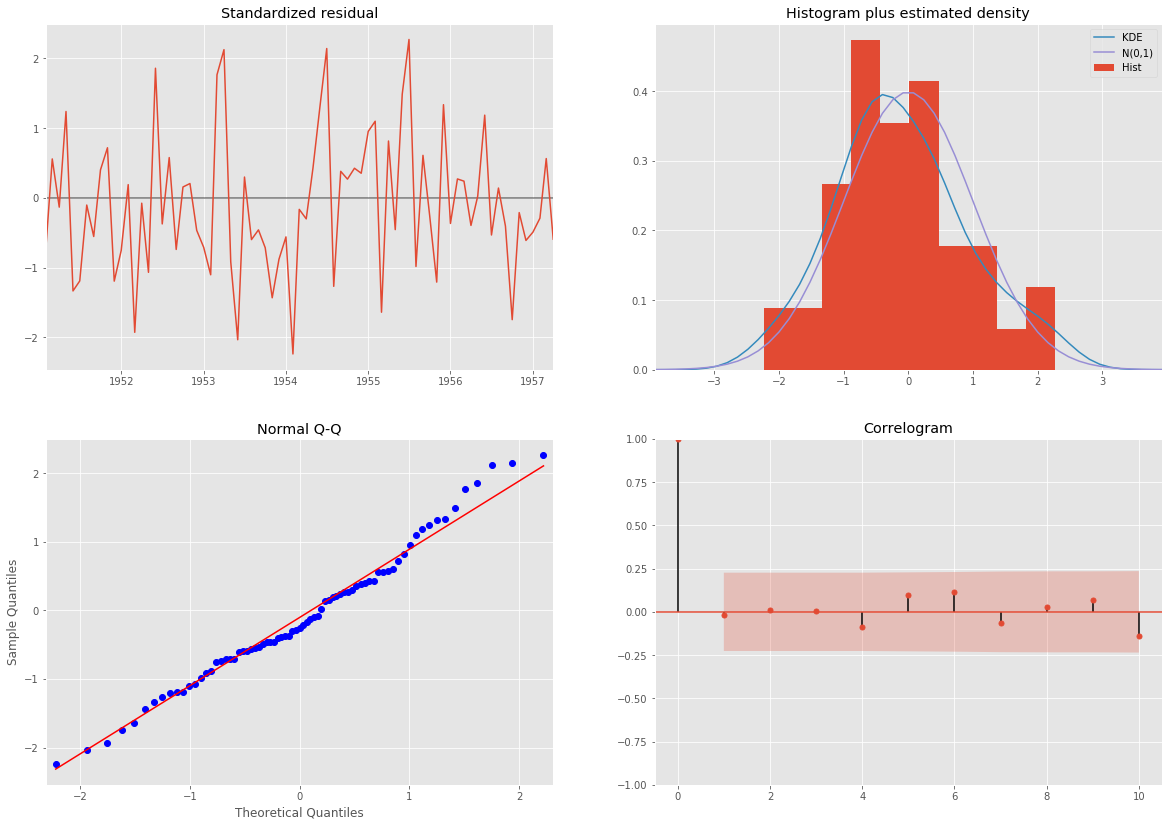

In [66]:
fig = model.plot_diagnostics(figsize=(20,14))

In [67]:
df.tail()

,Passengers
TravelDate,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


### Predicting future years (1961 - 1963)

In [68]:
final_model = auto_arima(df, start_p=0, start_q=0, max_p=8, max_q=8, start_P=0, start_Q=0, max_P=8, max_Q=8, m=12, seasonal=True, trace=True,
                   d=1, D=1, error_action='warn', suppress_warnings=True, stepwise=True, random_state=20, n_fits=30)
                   
final_model.fit(df)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1033.479, BIC=1039.229, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1022.316, BIC=1033.817, Fit time=0.457 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1022.904, BIC=1034.405, Fit time=0.574 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1022.343, BIC=1030.968, Fit time=0.187 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1021.142, BIC=1035.518, Fit time=1.253 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1016.960, BIC=1034.211, Fit time=3.085 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(3, 1, 2, 12); AIC=1019.701, BIC=1042.702, Fit time=5.048 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1033.371, BIC=1047.747, Fit time=3.046 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1018.094, BIC=1038.221, Fit time=3.142 seconds
Fit ARIMA: order=(1, 1, 1) s

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [69]:
# create a future data range for prediction index
datelist = pd.date_range(start="1961-1-1", end="1963-12-1", freq="MS").tolist()

In [148]:
# create predictions and variable for confidence intervals
forecast, confint = final_model.predict(n_periods=36, return_conf_int=True)

In [149]:
# map predictions to the date range created
forecast = pd.DataFrame(forecast, index=datelist, columns=['Auto_ARIMA'])

In [156]:
# map confidence intervals to the data range created
lower_series = pd.Series(confint[:, 0], index=datelist)
upper_series = pd.Series(confint[:, 1], index=datelist)

forecast['Lower CI'] = lower_series
forecast['Upper CI'] = upper_series

In [157]:
forecast.tail()

,Auto_ARIMA,Lower CI,Upper CI
1963-08-01,761.011651,599.817650,922.205651
1963-09-01,644.428730,478.090711,810.766748
1963-10-01,588.630172,417.305168,759.955177
1963-11-01,512.972535,336.796414,689.148656
1963-12-01,562.317004,381.433184,743.200823


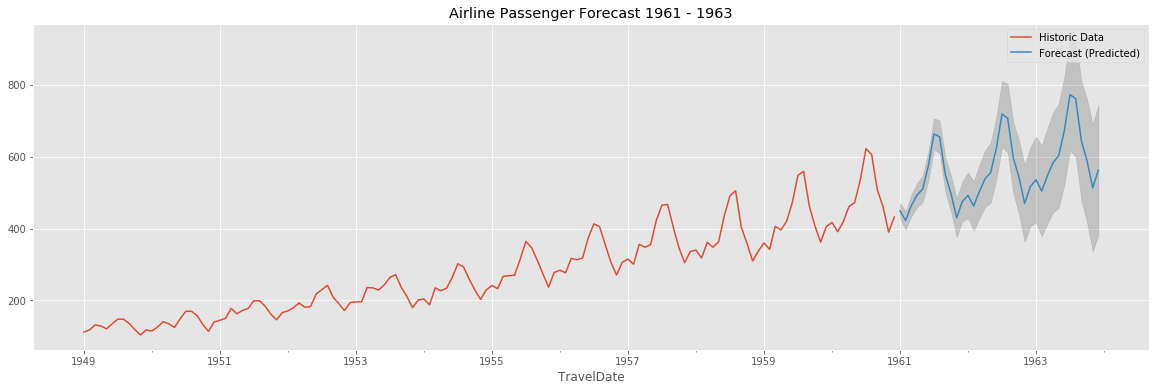

In [162]:
# plot forecast vs historic
df['Passengers'].plot(figsize=(15,6))
forecast['Auto_ARIMA'].plot(figsize=(20,6))

# plot lower vs upper confidence intervals
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend(['Historic Data','Forecast (Predicted)'])
plt.title("Airline Passenger Forecast 1961 - 1963")
plt.show()

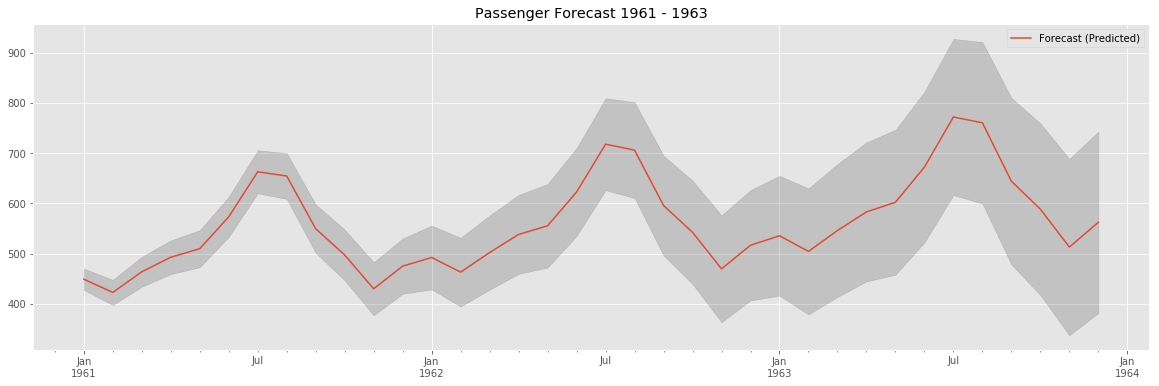

In [159]:
# plot forecasted predictions
forecast['Auto_ARIMA'].plot(figsize=(20,6))
# plot lower vs upper confidence intervals
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend(['Forecast (Predicted)'])
plt.title("Passenger Forecast 1961 - 1963")
plt.show()

In [160]:
# print final forecast
forecast

,Auto_ARIMA,Lower CI,Upper CI
1961-01-01,448.868328,427.506807,470.229848
1961-02-01,422.519663,397.360720,447.678605
1961-03-01,463.642032,433.657130,493.626935
1961-04-01,492.679845,459.073438,526.286252
1961-05-01,509.751441,472.699111,546.803772
1961-06-01,573.322354,533.180734,613.463974
1961-07-01,663.264296,620.232832,706.295761
1961-08-01,654.750423,609.019160,700.481687
1961-09-01,549.655039,501.371761,597.938317
1961-10-01,497.193619,446.488075,547.899164
